Date: May 2022

This code is to apply D/U-EquiStatic graphs to decentralized SGD for solving least square problems. The static exponential graph is included for comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from topology_util import *
from EquiTopo import *

### Problem

Assume the network size is $n$. At each agent/node $i$, the distributed least square problems are defined by
$$f_i(x):=||A_i x - b_i||^2,$$
where $x\in\mathbb{R}^d$ and $A_i\in \mathbb{K\times d}$. The parameter $K$ is the local data size. In this experiment, we generate elements in $A_i$ from a standard normal distribution. For given $x$, the label $b_i$ is generated by $b_i = A_i x + s_i$, where $s_i\sim \mathcal{N}(0, \sigma_s^2 I)$ is a white noise.

In [3]:
# Gradient utility
def ls_full_grad_dist(X, y, W):
    
    n, m = X.shape
    Q = W.shape[0]
    N_agent = n//Q    
    
    G = np.zeros((Q, m))
    
    for k in range(Q):
        
        wk = W[k,:].reshape(m, 1)        
        Xk = X[k*N_agent:(k+1)*N_agent, :]
        yk = y[k*N_agent:(k+1)*N_agent].reshape(N_agent, 1)

        grad = Xk.T@(Xk@wk-yk)
        G[k,:] = grad.T
    
    return G

In [4]:
# Data generation utility
# Sigma_n is set to be 0.1.
# N = K * n 
def genLS(N, d):
    A = np.random.randn(N, d)
    b = A @ np.random.randn(d, 1) + 0.1 * np.random.randn(N, 1)
    return A, b

In [5]:
# Solution utility
def solLS(A, b):
    x_sol = np.linalg.inv(A.T@A)@(A.T@b)
    print(A.T@(A@x_sol-b))
    return x_sol

Here, we use decentralized SGD with D/U-EquiStatic to solve this problem by generating a stochastic gradient via
$$\widehat{\nabla f_i}(x) = \nabla f_i(x) + n_i,$$
where $n_i\sim \mathcal{N}(0, \sigma_n^2 I)$ is a white gradient noise.

In [6]:
# DSGD -- traning utility 
def train_static(n, d, X_sol, A, b, W, noise_mag, maxite, mu_init, exp_repeat, mu_decay=0, mu_min=0, period=10000):
    DSGD_loss_record_ave = np.zeros((maxite, 1))

    for e in range(exp_repeat):

        DSGD_loss_record = np.zeros((maxite, 1))

        print("DSGD Repeat:", e)
        
        X = np.zeros((n, d))
        mu = mu_init
        
        for ite in range(maxite):

            if (ite+1)%period == 0:
                mu = mu/mu_decay
                mu = max(mu, mu_min)
                print ('DSGD iteration:', ite)

            G = ls_full_grad_dist(A, b, X)
            V = np.random.randn(n, d)  # Gaussian noise
            X = W @ (X - mu * (G + noise_mag*V))

            # record loss
            DSGD_loss_record[ite] = np.linalg.norm(X-X_sol,'fro')/np.linalg.norm(X_sol,'fro')
            
        DSGD_loss_record_ave += DSGD_loss_record
           
    DSGD_loss_record_ave = DSGD_loss_record_ave/exp_repeat
    return DSGD_loss_record_ave 


#### Parameters

In [8]:
# network size
n= 300
# number of features
d = 10
# local data size is 50
N = n * 50

noise_mag = 1
maxite = 100
mu_init = 0.037
exp_repeat = 10

mu_decay = 1.4
mu_min = 0.001
period = 40

#### Generating data

In [9]:
np.random.seed(0)
A, b = genLS(N, d)
x_sol = solLS(A, b)
X_sol = np.ones((n,1))@x_sol.T

[[ 2.51862347e-11]
 [-8.15360215e-11]
 [ 1.74083675e-12]
 [-5.19584360e-12]
 [ 4.06798277e-12]
 [ 8.79977174e-11]
 [-5.30175289e-12]
 [ 1.87252329e-13]
 [-1.39972364e-11]
 [-2.94203089e-11]]


#### Generating communication topologies and running DSGD

In [ ]:
W_exp, _, _ = ExponentialGraph(n)
m = np.count_nonzero(W_exp[0])
print(m)
W_undi, Ms1 = UEquiStatic(n, M=m-1)
W_di, Ms2 = DEquiStatic(n, M=m-1)
exp_loss = train_static(n, d, X_sol, A, b, W_exp, noise_mag, maxite, mu_init, exp_repeat, mu_decay=mu_decay, mu_min=mu_min, period=period)
undi_loss = train_static(n, d, X_sol, A, b, W_undi, noise_mag, maxite, mu_init, exp_repeat, mu_decay=mu_decay, mu_min=mu_min, period=period)
di_loss = train_static(n, d, X_sol, A, b, W_di, noise_mag, maxite, mu_init, exp_repeat, mu_decay=mu_decay, mu_min=mu_min, period=period)


In [11]:
# Computing the second largest eigenvalue for each topology for references
w_exp, v = np.linalg.eig(W_exp)
e_exp = sorted(abs(w_exp))[-2]

w_undi, v = np.linalg.eig(W_undi)
e_undi = sorted(abs(w_undi))[-2]

w_di, v = np.linalg.eig(W_di)
e_di = sorted(abs(w_di))[-2]

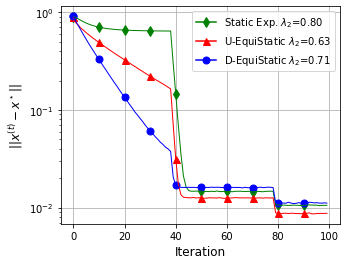

In [12]:
# plot the results
plt.rcParams['figure.figsize'] = 5, 4
plt.figure()
xlen = maxite

plt.semilogy(0, exp_loss[0], color='green', marker='d', markersize = 7)
plt.semilogy(0, undi_loss[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, di_loss[0], color='blue', marker='o', markersize = 7)

idx_set = np.arange(0, xlen, xlen//10)
plt.semilogy(idx_set, exp_loss[idx_set], color='green', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, undi_loss[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, di_loss[idx_set], color='blue', marker='o', markersize = 7, linestyle = 'None')

plt.semilogy(np.arange(xlen), exp_loss, linewidth=1.0, color='green')
plt.semilogy(np.arange(xlen), undi_loss, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), di_loss, linewidth=1.0, color='blue')

plt.legend(['Static Exp. $\lambda_2$={:.2f}'.format(e_exp), 'U-EquiStatic $\lambda_2$={:.2f}'.format(e_undi), 'D-EquiStatic $\lambda_2$={:.2f}'.format(e_di)], fontsize=10)
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel(r'$||x^{(t)} - x^\star||$', fontsize = 12)
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()